In [1]:
from IPython.display import Audio

In [2]:
import torch
from torch import optim
from torch.nn.functional import cross_entropy
import torchaudio
import torchaudio.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
from src.custom_audio_dataset import CustomAudioDataset
from src.models import CnnMFCC
from src.utils import pad_collate_fn, plot_spectrogram
from src.datasets import get_data_path
from src import custom_layers
from src.hesitation import coraa_filters

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_EPOCH = 15

TRAIN_SIZE = 0.7
TEST_FROM_VAL_SIZE = 0.5

SAMPLE_RATE = 16_000
MAX_SECONDS_DURATION = 10

MAX_FEATURES_IN = SAMPLE_RATE * MAX_SECONDS_DURATION
DEVICE

'cuda'

In [7]:
annotations_file_path, data_dir_path = get_data_path("hesitation_dev")

train_filter_annotations_file, val_filter_annotations_file, test_filter_annotations_file = coraa_filters.filter2(
    annotations_file_path, train_size=TRAIN_SIZE, test_size_from_val_size=TEST_FROM_VAL_SIZE
	)

In [8]:
train_data_transform = torch.nn.Sequential(
    # custom_layers.RandomPitchShiftLayer(p=0.001, sample_rate=SAMPLE_RATE, min_steps=-5, max_steps=5), # too heavy
    # custom_layers.ReverberationLayer(1,400), # not working yet
    custom_layers.PadOrTruncateLayer(MAX_FEATURES_IN),
    #custom_layers.NoiseLayer(p=0.5, noise_factor=0.1),
)
data_transform = torch.nn.Sequential(
    custom_layers.PadOrTruncateLayer(MAX_FEATURES_IN),
)

train_filter_dataset = CustomAudioDataset(train_filter_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=train_data_transform)
val_filter_dataset = CustomAudioDataset(val_filter_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=data_transform)
test_filter_dataset = CustomAudioDataset(test_filter_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=data_transform)

# Usage in DataLoader
train_filter_dataloader = torch.utils.data.DataLoader(
    dataset=train_filter_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)
val_filter_dataloader = torch.utils.data.DataLoader(
    dataset=val_filter_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)
test_filter_dataloader = torch.utils.data.DataLoader(
    dataset=test_filter_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)

len(train_filter_dataset), len(val_filter_dataset), len(test_filter_dataset)

(125, 27, 28)

In [9]:
# example of data augmentation

with torch.no_grad():
	test_waveform, test_sample_rate = torchaudio.load("temp_datasets/hesitation_dev/dev/NURC_RE/NURC_RE_EF/NURC_RE_EF_171/151591_nurc_.wav")

	resampler = T.Resample(test_sample_rate, SAMPLE_RATE, dtype=test_waveform.dtype)
	test_waveform = resampler(test_waveform)
	test_waveform = train_data_transform(test_waveform)
	# reverb = custom_layers.ReverberationLayer()
	# test_waveform = reverb(test_waveform)

print(test_waveform.shape)
Audio(test_waveform, rate=SAMPLE_RATE)

torch.Size([1, 160000])


In [10]:
model = CnnMFCC(n_classes=2, sample_rate=SAMPLE_RATE, max_audio_length_seconds=MAX_SECONDS_DURATION)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

# early_stopping_patience = 5  # Number of epochs to wait before stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3)

model

/home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


CnnMFCC(
  (feature_extractor): Sequential(
    (0): MFCC(
      (amplitude_to_DB): AmplitudeToDB()
      (MelSpectrogram): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
    )
  )
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.7, inplace=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.7, inplace=True)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPoo

torch.Size([1, 40, 801])


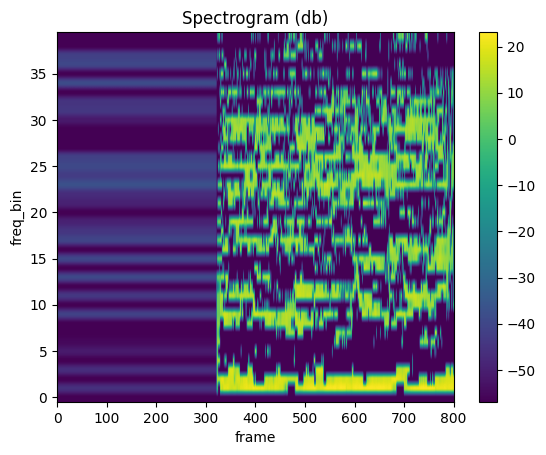

In [11]:
test_feature = model.feature_extractor(test_waveform.to(DEVICE))
print(test_feature.shape)
plot_spectrogram(test_feature.cpu().numpy()[0])

In [15]:
for i in range(MAX_EPOCH):
	model.train()
	losses = []
	for batch_idx, (data, target) in enumerate(train_filter_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
	
	model.eval()
	val_losses = []
	for batch_idx, (data, target) in enumerate(val_filter_dataloader):
		with torch.no_grad():
			data, target = data.to(DEVICE), target.to(DEVICE)
			logits = model(data)
			loss = cross_entropy(logits, target)
			val_losses.append(loss.item())
	val_loss = sum(val_losses)/len(val_losses)
	scheduler.step(val_loss)
	
	print(f"epoch: {i+1}: train_loss = {sum(losses)/len(losses)}, val_loss = {val_loss}, lr={scheduler.get_last_lr()}")

epoch: 1: train_loss = 1.414540946483612, val_loss = 0.7285414338111877, lr=[0.000343]
epoch: 2: train_loss = 1.0863497406244278, val_loss = 0.7256335020065308, lr=[0.00024009999999999998]
epoch: 3: train_loss = 1.2424973845481873, val_loss = 0.7242072224617004, lr=[0.00024009999999999998]
epoch: 4: train_loss = 1.0221263468265533, val_loss = 0.7225494980812073, lr=[0.00024009999999999998]
epoch: 5: train_loss = 1.210473671555519, val_loss = 0.7210280299186707, lr=[0.00024009999999999998]
epoch: 6: train_loss = 1.2076669484376907, val_loss = 0.7207591533660889, lr=[0.00016806999999999998]
epoch: 7: train_loss = 1.2676564157009125, val_loss = 0.7221994996070862, lr=[0.00016806999999999998]
epoch: 8: train_loss = 1.3167360424995422, val_loss = 0.7239910364151001, lr=[0.00016806999999999998]
epoch: 9: train_loss = 1.1809111535549164, val_loss = 0.7249990105628967, lr=[0.00016806999999999998]
epoch: 10: train_loss = 1.275774598121643, val_loss = 0.7261312007904053, lr=[0.000117648999999999

In [13]:
model.eval()
preds = []
targets = []
losses = []
with torch.no_grad():
	for batch_idx, (data, target) in enumerate(test_filter_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		preds.append(torch.max(logits, dim=1).indices)
		targets.append(target)
	print(f"test_loss = {sum(losses)/len(losses)}")

preds = torch.concat(preds)
targets = torch.concat(targets)

print(f"test_accuracy: {sum(preds == targets)/len(preds)}")

test_loss = 0.7303890585899353
test_accuracy: 0.4285714626312256


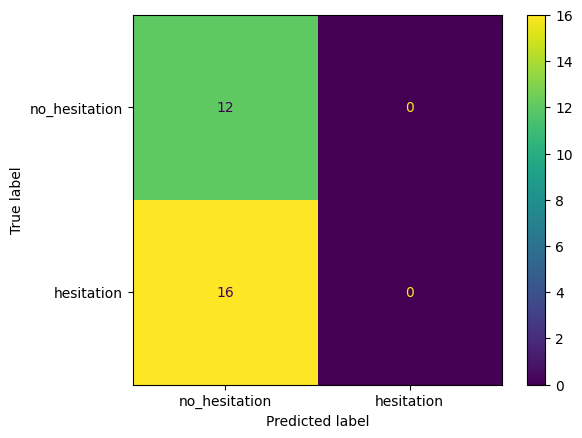

In [14]:
cm =confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no_hesitation', 'hesitation'])

disp.plot()
plt.show()